<a href="https://colab.research.google.com/github/AdityaBala05/YOLO-image-classification/blob/main/Eigencam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"/content/drive/MyDrive/YoloDataset/custom_yolov8_classification3/weights/best.pt"
"/content/drive/MyDrive/Acne.1.jpg"

'/content/drive/MyDrive/Acne.1.jpg'

# EigenCam for YOLO

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, Normalize, ToTensor
from typing import List, Dict
import math


def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)


def deprocess_image(img):
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def create_labels_legend(concept_scores: np.ndarray,
                         labels: Dict[int, str],
                         top_k=2):
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{','.join(labels[category].split(',')[:3])}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk


def show_factorization_on_image(img: np.ndarray,
                                explanations: np.ndarray,
                                colors: List[np.ndarray] = None,
                                image_weight: float = 0.5,
                                concept_labels: List = None) -> np.ndarray:
    """ Color code the different component heatmaps on top of the image.
        Every component color code will be magnified according to the heatmap itensity
        (by modifying the V channel in the HSV color space),
        and optionally create a lagend that shows the labels.

        Since different factorization component heatmaps can overlap in principle,
        we need a strategy to decide how to deal with the overlaps.
        This keeps the component that has a higher value in it's heatmap.

    :param img: The base image RGB format.
    :param explanations: A tensor of shape num_componetns x height x width, with the component visualizations.
    :param colors: List of R, G, B colors to be used for the components.
                   If None, will use the gist_rainbow cmap as a default.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * visualization.
    :concept_labels: A list of strings for every component. If this is paseed, a legend that shows
                     the labels and their colors will be added to the image.
    :returns: The visualized image.
    """
    n_components = explanations.shape[0]
    if colors is None:
        # taken from https://github.com/edocollins/DFF/blob/master/utils.py
        _cmap = plt.cm.get_cmap('gist_rainbow')
        colors = [
            np.array(
                _cmap(i)) for i in np.arange(
                0,
                1,
                1.0 /
                n_components)]
    concept_per_pixel = explanations.argmax(axis=0)
    masks = []
    for i in range(n_components):
        mask = np.zeros(shape=(img.shape[0], img.shape[1], 3))
        mask[:, :, :] = colors[i][:3]
        explanation = explanations[i]
        explanation[concept_per_pixel != i] = 0
        mask = np.uint8(mask * 255)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
        mask[:, :, 2] = np.uint8(255 * explanation)
        mask = cv2.cvtColor(mask, cv2.COLOR_HSV2RGB)
        mask = np.float32(mask) / 255
        masks.append(mask)

    mask = np.sum(np.float32(masks), axis=0)
    result = img * image_weight + mask * (1 - image_weight)
    result = np.uint8(result * 255)

    if concept_labels is not None:
        px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
        fig = plt.figure(figsize=(result.shape[1] * px, result.shape[0] * px))
        plt.rcParams['legend.fontsize'] = int(
            14 * result.shape[0] / 256 / max(1, n_components / 6))
        lw = 5 * result.shape[0] / 256
        lines = [Line2D([0], [0], color=colors[i], lw=lw)
                 for i in range(n_components)]
        plt.legend(lines,
                   concept_labels,
                   mode="expand",
                   fancybox=True,
                   shadow=True)

        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.axis('off')
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        plt.close(fig=fig)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = cv2.resize(data, (result.shape[1], result.shape[0]))
        result = np.hstack((result, data))
    return result


def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result


def scale_accross_batch_and_channels(tensor, target_size):
    batch_size, channel_size = tensor.shape[:2]
    reshaped_tensor = tensor.reshape(
        batch_size * channel_size, *tensor.shape[2:])
    result = scale_cam_image(reshaped_tensor, target_size)
    result = result.reshape(
        batch_size,
        channel_size,
        target_size[1],
        target_size[0])
    return result

In [ ]:
import numpy as np
import torch
import torchvision


class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


class ClassifierOutputSoftmaxTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return torch.softmax(model_output, dim=-1)[self.category]
        return torch.softmax(model_output, dim=-1)[:, self.category]


class BinaryClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if self.category == 1:
            sign = 1
        else:
            sign = -1
        return model_output * sign


class SoftmaxOutputTarget:
    def __init__(self):
        pass

    def __call__(self, model_output):
        return torch.softmax(model_output, dim=-1)


class RawScoresOutputTarget:
    def __init__(self):
        pass

    def __call__(self, model_output):
        return model_output


class SemanticSegmentationTarget:
    """ Gets a binary spatial mask and a category,
        And return the sum of the category scores,
        of the pixels in the mask. """

    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, :] * self.mask).sum()


class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

In [ ]:
import numpy as np

def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

In [ ]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

In [ ]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple



class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 task: str = 'od',
                 #use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model
        self.target_layers = target_layers
        self.task = task
        #self.cuda = use_cuda
        #if self.cuda:
        #    self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)
        self.outputs = []

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: np.array,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")

    def get_cam_image(self,
                      input_tensor: np.array,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: np.array,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

#         if self.cuda:
#             input_tensor = torch.tensor(input_tensor).cuda()

#         if self.compute_input_gradient:
#             input_tensor = torch.autograd.Variable(input_tensor,
#                                                    requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        self.outputs.append(outputs[0])
        if targets is None:
#             target_categories = np.argmax(outputs[0].cpu().data.numpy(), axis=-1)
            if self.task == 'od':
                target_categories = outputs[0].boxes.cls
            elif self.task == 'cls':
                # Change
                # target_categories = [np.argmax(outputs[0].probs.cpu().numpy())]
                target_categories = outputs[0].probs.top5
            elif self.task == 'seg':
                target_categories = [category['name'] for category in outputs[0].summary()]
            else:
                print('Invalid Task Entered')
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: np.array) -> Tuple[int, int]:
        height, width = np.shape(input_tensor)[0],np.shape(input_tensor)[1]
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: np.array,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: np.array,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: np.array,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [ ]:



class EigenCAM(BaseCAM):
    def __init__(self, model, target_layers, task: str = 'od', #use_cuda=False,
                 reshape_transform=None):
        super(EigenCAM, self).__init__(model,
                                       target_layers,
                                       task,
                                       #use_cuda,
                                       reshape_transform,
                                       uses_gradients=False)

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth):
        return get_2d_projection(activations)

In [ ]:



img = cv2.imread("/content/drive/MyDrive//YoloDataset/dataset/test/Psoriasis/image_117.jpg")
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [ ]:
model = YOLO("/content/drive/MyDrive/YoloDataset/custom_yolov8_classification3/weights/best.pt")
model = model.cpu()

In [ ]:
target_layers =[model.model.model[-2]]

In [ ]:
cam = EigenCAM(model, target_layers,task='cls')


0: 320x320 Psoriasis 1.00, AK 0.00, Melanoma 0.00, Acne 0.00, 646.1ms
Speed: 8.8ms preprocess, 646.1ms inference, 0.1ms postprocess per image at shape (1, 3, 320, 320)


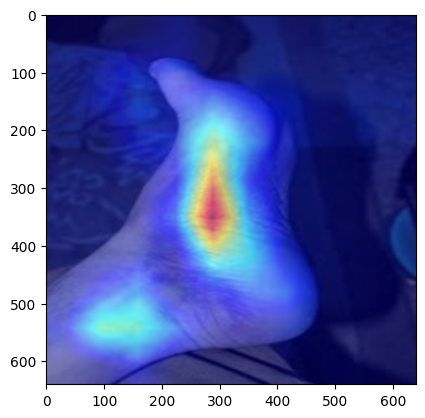

In [ ]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()